In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

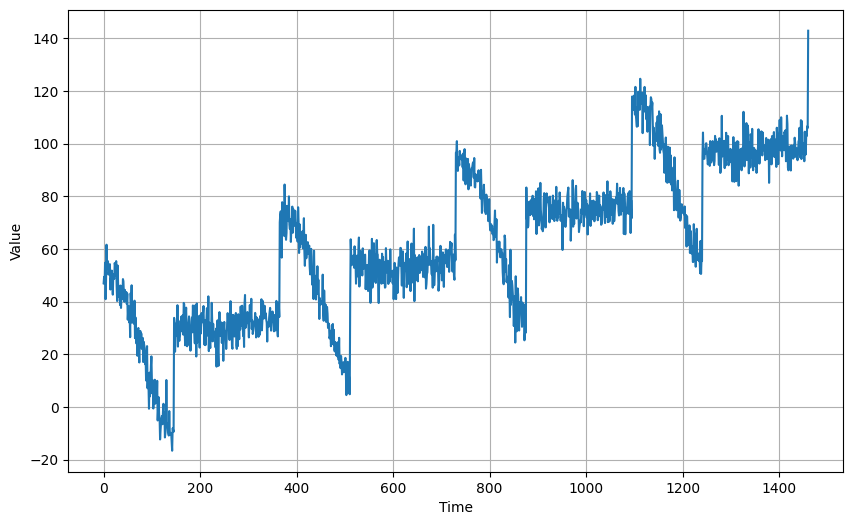

In [3]:
time=np.arange(4*365+1,dtype="float32")
baseline=10
slope=0.06
noise_level=5
amplitude=40

series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)

series+=noise(time,noise_level,seed=40)

plot_series(time,series)

In [4]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

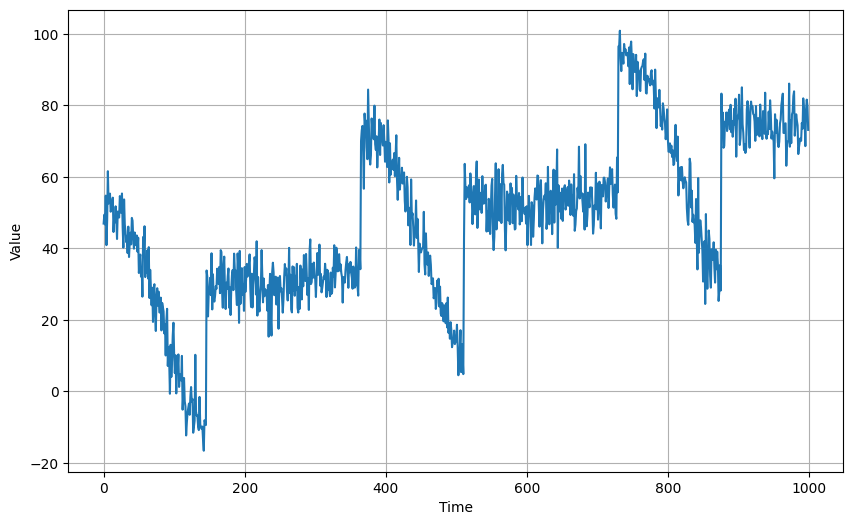

In [5]:
plot_series(time_train,x_train)


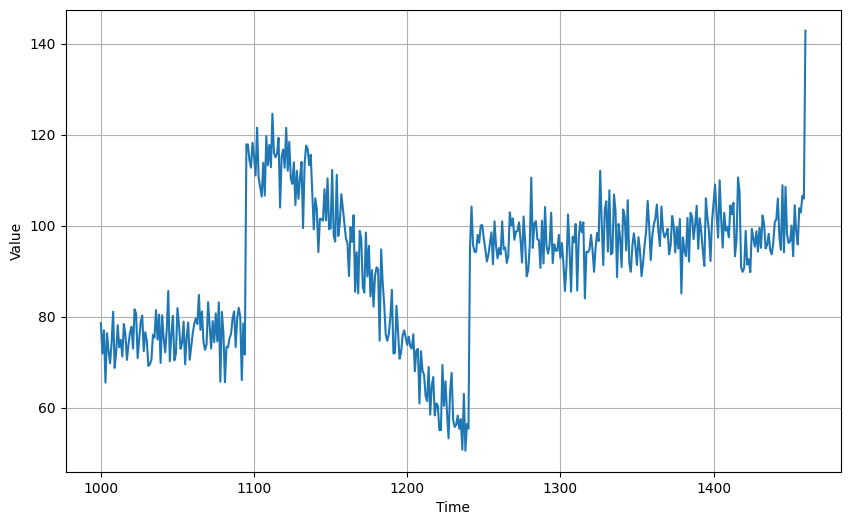

In [6]:
plot_series(time_valid,x_valid)

In [7]:
window_size=20
batch_size=32
shuffle_buffer_size=1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [12]:
dataset=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [13]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


In [14]:
l0=tf.keras.layers.Dense(1,input_shape=[window_size])
model=tf.keras.models.Sequential([l0])

print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[ 0.5100134 ],
       [ 0.4503739 ],
       [ 0.14708143],
       [-0.08639139],
       [ 0.39556038],
       [ 0.08386016],
       [-0.04657948],
       [ 0.48614806],
       [-0.04859316],
       [-0.24405605],
       [-0.4394123 ],
       [-0.09484819],
       [ 0.08523613],
       [ 0.25157797],
       [-0.16019386],
       [ 0.52437824],
       [ 0.38841367],
       [-0.5206422 ],
       [ 0.4080577 ],
       [-0.49391356]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss="mse",optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9))

In [16]:
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 5ms/step - loss: 483.5667
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 246.8576
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 195.3977
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 163.9266
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 147.2541
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 133.0611
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 119.7618
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 112.9501
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 108.4200
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 105.2714
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 100.7842
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 97.9467
Epoch 13/100
3

In [17]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.00322301],
       [-0.00768282],
       [-0.06159207],
       [ 0.02491377],
       [ 0.04962005],
       [-0.02300921],
       [-0.02370382],
       [ 0.0883735 ],
       [-0.02126216],
       [-0.01402173],
       [-0.054155  ],
       [ 0.02915519],
       [-0.02468467],
       [ 0.04430203],
       [-0.05416452],
       [ 0.15853223],
       [ 0.1024951 ],
       [ 0.05631537],
       [ 0.31345832],
       [ 0.40067375]], dtype=float32), array([0.01165669], dtype=float32)]


In [19]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][expand_dims]: {np.expand_dims(series[0:20],axis=0).shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')


shape of series[0:20]: (20,)
shape of series[0:20][expand_dims]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 35ms/step
model prediction: [[45.62827]]


In [20]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 21ms/step
length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


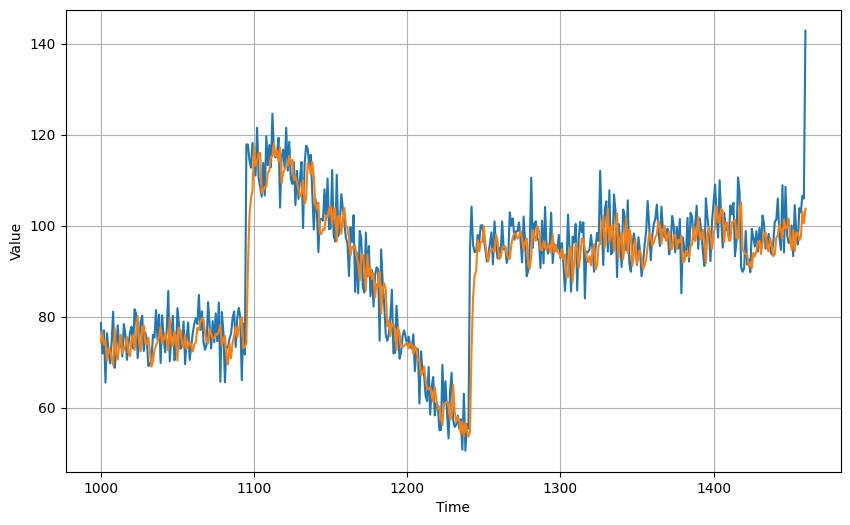

In [21]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

In [22]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

48.87998
5.081407
